In [3]:


from sim_lid_scan import simulate_lidar_scan
from conversion import gps_to_local, polar_to_cartesian, lidar_to_map

import numpy as np
import matplotlib.pyplot as plt

In [4]:
scan = simulate_lidar_scan(0,0)
scan

[{'angle_deg': 0, 'distance_mm': 18000, 'new_scan': True},
 {'angle_deg': 1, 'distance_mm': 17996, 'new_scan': False},
 {'angle_deg': 2, 'distance_mm': 17985, 'new_scan': False},
 {'angle_deg': 3, 'distance_mm': 17989, 'new_scan': False},
 {'angle_deg': 4, 'distance_mm': 17987, 'new_scan': False},
 {'angle_deg': 5, 'distance_mm': 17997, 'new_scan': False},
 {'angle_deg': 6, 'distance_mm': 17994, 'new_scan': False},
 {'angle_deg': 7, 'distance_mm': 18000, 'new_scan': False},
 {'angle_deg': 8, 'distance_mm': 18000, 'new_scan': False},
 {'angle_deg': 9, 'distance_mm': 17991, 'new_scan': False},
 {'angle_deg': 10, 'distance_mm': 18000, 'new_scan': False},
 {'angle_deg': 11, 'distance_mm': 18000, 'new_scan': False},
 {'angle_deg': 12, 'distance_mm': 18000, 'new_scan': False},
 {'angle_deg': 13, 'distance_mm': 11191, 'new_scan': False},
 {'angle_deg': 14, 'distance_mm': 10989, 'new_scan': False},
 {'angle_deg': 15, 'distance_mm': 11011, 'new_scan': False},
 {'angle_deg': 16, 'distance_mm': 1

In [5]:
def plot_scan(scan,x_d,y_d):
    xs=[]
    ys=[]
    for point in scan:

        x,y=polar_to_cartesian(point["angle_deg"],point["distance_mm"])
        xs.append(x+x_d)
        ys.append(y+y_d)
    
    plt.figure(figsize=(6,6))
    plt.scatter(xs, ys, s=5)
    plt.scatter(x_d, y_d, c='red', label="LiDAR")  # LiDAR
    plt.axis("equal")
    plt.grid()
    plt.legend()
    plt.show()

def plot_points(points):
    xs=[]
    ys=[]
    for point in points:

        x,y=point
        xs.append(x)
        ys.append(y)
    
    plt.figure(figsize=(6,6))
    plt.scatter(xs, ys, s=5)
    plt.scatter(0, 0, c='red', label="LiDAR")  # LiDAR
    plt.axis("equal")
    plt.grid()
    plt.legend()
    plt.show()

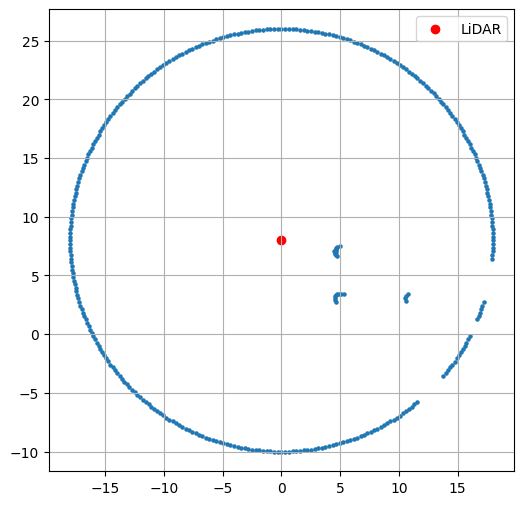

In [6]:
x_d, y_d = 0.0, 8.0  # coordinates of the drone in the map  frame ( will get from the gps and imu  )
scan = simulate_lidar_scan(x_d, y_d)
plot_scan(scan,x_d=x_d,y_d=y_d)

In [7]:
from filtering import range_filter,std_filter,point_cloud_average
from downsampling import angular_downsample
from conversion import polar_to_cartesian   

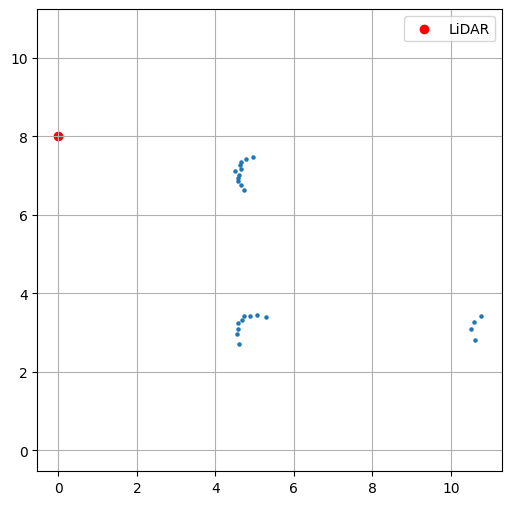

In [8]:
filtered_scan=range_filter(scan, min_range=200, max_range=15000)
plot_scan(filtered_scan,x_d=x_d,y_d=y_d)


In [9]:
len(filtered_scan)

24

In [10]:
points=[]
for point in filtered_scan:
	x, y = polar_to_cartesian(point['angle_deg'], point['distance_mm'])
	points.append((x, y))
	
	

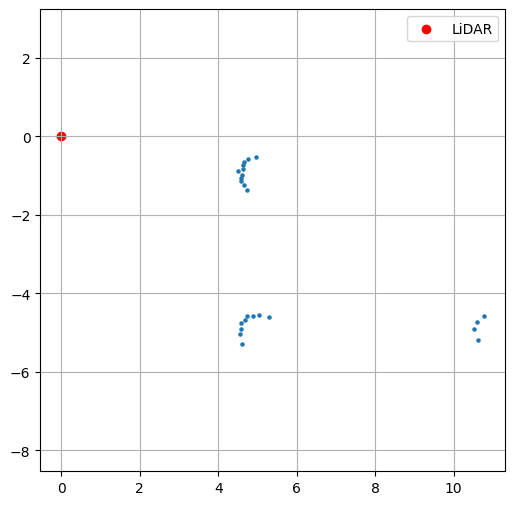

In [11]:
plot_points(points)

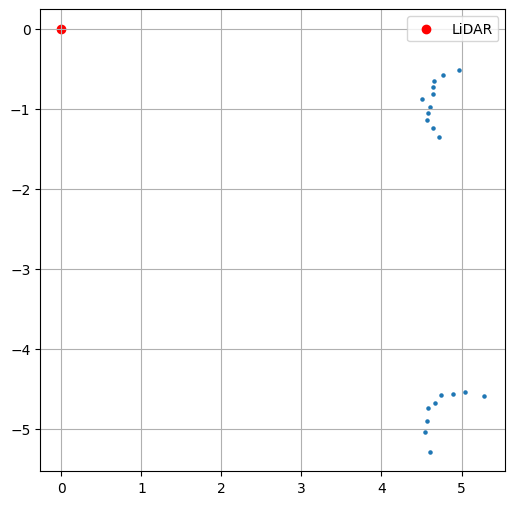

In [12]:
filtered_std=std_filter(points, k=1.5)
filtered_std
plot_points(filtered_std)
                        

In [13]:
# p2=point_cloud_average(filtered_std, window=1)
# plot_points(p2)

In [14]:
downsampled_scan = angular_downsample(filtered_std, step_deg=1.0)
downsampled_scan

[(4.600285911281436, -5.292023576522078),
 (4.544735078389362, -5.047439654642464),
 (4.572799004219053, -4.903726569356537),
 (4.583355928288464, -4.746204002634419),
 (4.740449284231709, -4.577798661324794),
 (4.894218971235491, -4.563933025538239),
 (5.0489259442934165, -4.546073339602082),
 (4.722678712144961, -1.354206329128916),
 (4.567181983581115, -1.1387263625876367),
 (4.58051367455539, -1.0574949064705108),
 (4.604140756654023, -0.9786403286791957),
 (4.504687144841331, -0.8756224797829636),
 (4.638184447434766, -0.7346162478289252),
 (4.659211263429088, -0.65480944001711),
 (4.769184258636552, -0.5855821950617324),
 (4.963658779783052, -0.5217015601688582)]

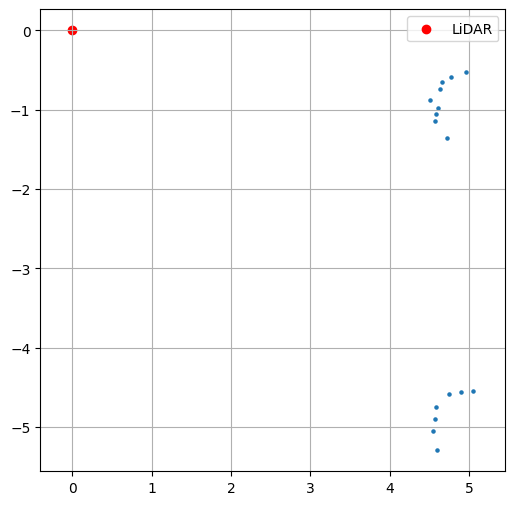

In [15]:
plot_points(downsampled_scan)

In [16]:
# Drone pose (simulated)
# x_d, y_d = 5.0, 0.0  # coordinates of the drone in the map  frame ( will get from the gps and imu  )
# yaw = 0.0  # degrees

In [17]:
# drone_pose = (x_d, y_d, yaw)

In [18]:
from rplidar import RPLidar

PORT_NAME = 'COM17'
BAUDRATE = 1000000


def get_single_lidar_scan():
    """
    Returns ONE full 360° LiDAR scan
    Output format:
    [
        {
            "angle": float (deg),
            "distance": float (mm),
            "quality": int
        },
        ...
    ]
    """
    lidar = RPLidar(PORT_NAME, baudrate=BAUDRATE)

    try:
        print("LiDAR Info:", lidar.get_info())
        print("LiDAR Health:", lidar.get_health())

        for scan in lidar.iter_scans(max_buf_meas=500):
            scan_data = []

            for (quality, angle, distance) in scan:
                scan.append({
                    "angle_deg": angle,
                    "distance_mm": distance,
                    "quality": quality
                })

            return scan_data   # <-- ONE scan only

    finally:
        lidar.stop()
        lidar.disconnect()


In [19]:
import redis
import time
import json
import random

# Connect to Redis
r = redis.Redis(host='localhost', port=6379, decode_responses=True)

while True:
    #get random drone pose for testing
    x_d= random.uniform(-10,10)
    y_d= random.uniform(-10,10)
    yaw= 0.0
    scan = simulate_lidar_scan(x_d, y_d)
  
    drone_pose = (x_d, y_d, yaw)

    filtered_scan=range_filter(scan, min_range=200, max_range=15000)
    
    points=[]
    for point in filtered_scan:
        x, y = polar_to_cartesian(point['angle_deg'], point['distance_mm'])
        points.append((x, y))

    filtered_std=std_filter(points, k=1.5)

	# p2=point_cloud_average(filtered_std, window=1)
    # plot_points(p2)
    downsampled = angular_downsample(filtered_std, step_deg=1.0)

    message = {
        "timestamp": time.time(),
        "drone_pose": drone_pose,
        "points": downsampled
    }

  
    r.publish("lidar:scan", json.dumps(message))

    print("Published:", message)
    time.sleep(0.2)  # 5 Hz
    


Published: {'timestamp': 1767550701.7933867, 'drone_pose': (-3.2712602880107884, 8.745494075839638, 0.0), 'points': [(7.846655828442614, -5.700929161984699), (7.864678777218609, -5.506907365406398), (7.957102621383292, -5.367133487512226), (8.130911156230887, -5.2802754444706865), (7.846781538393984, -1.956422369714514), (7.808601699188873, -1.8027577495117366), (7.832027839075581, -1.6647489083778033), (7.854980721948208, -1.5268535810031105), (8.101019769561319, -1.2830754822599755)]}
Published: {'timestamp': 1767550702.1116414, 'drone_pose': (2.165850771042905, 4.941303710188858, 0.0), 'points': [(3.009968344056082, 1.6004285575371016), (2.78427167316697, 1.6074999999999997), (2.6555042975751437, 1.5955879560713477), (2.6230127614118253, 1.6390402842733027), (2.602394772334651, 1.6900149256516293), (2.579135888218735, 1.7396491226974937), (2.5385521852515858, 1.7775133762518918), (2.497435461635463, 1.8144930738268648), (2.4813605297169388, 1.869839276933414), (2.434165217891164, 1.

KeyboardInterrupt: 

In [28]:
from conversion import gps_to_local, polar_to_cartesian, lidar_to_map

import numpy as np
import matplotlib.pyplot as plt

from filtering import range_filter,std_filter,point_cloud_average
from downsampling import angular_downsample
from conversion import polar_to_cartesian   

import redis
import time
import json
import random

from rplidar import RPLidar


# Connect to Redis
r = redis.Redis(host='localhost', port=6379, decode_responses=True)
x_d= random.uniform(-10,10)
y_d= random.uniform(-10,10)
yaw= 0.0

PORT_NAME='COM17'       # <-- YOUR COM PORT
BAUDRATE=1000000        # RPLIDAR S2 baudrate
MAX_BUFFER_SIZE=5000


lidar =RPLidar(PORT_NAME,baudrate=BAUDRATE)
drone_pose=(x_d,y_d,yaw)

try :
    # print("LiDAR Info:")
    # print(lidar.get_info())
    # print("LiDAR Health:")
    # print(lidar.get_health())
    for scan in lidar.iter_scans(max_buf_meas=MAX_BUFFER_SIZE):
        # # points are comming in as (quality, angle_deg, distance_mm)    
        print("raw scan",len(scan))
        filtered_scan=range_filter(scan,min_range=200,max_range=15000)
        print("new",len(filtered_scan))
        points=[]
        for point in filtered_scan: 
        
            x, y = polar_to_cartesian(point[1], point[2])
          
            points.append((x, y))

        # filtered_std=std_filter(points,k=1.5)
        # p2=point_cloud_average(filtered_std, window=1)
        # plot_points(p2)
        downsampled = angular_downsample(points, step_deg=1.0)
        message = {
            "timestamp": time.time(),
            "drone_pose": drone_pose,
            "points": downsampled
        }

        print("filtered points",len(downsampled))
        r.publish("lidar:scan", json.dumps(message))

        print("Published:", message)
        # time.sleep(0.02)  # 5 Hz


except Exception as e:
    print("Error connecting to LiDAR:", e)
    exit(1)
finally:
    lidar.stop()
    # lidar.disconnect()


RPLidarException: Failed to connect to the sensor due to: could not open port 'COM17': PermissionError(13, 'Access is denied.', None, 5)

In [ ]:
from pymavlink import mavutil
import time
import os
from geopy.distance import geodesic


In [ ]:
pubsub=r.pubsub()
pubsub.subscribe("drone:gps")
print("Subscribed to drone:gps channel")

for message in pubsub.listen():
    if message['type']=='message':
        gps_data=json.loads(message['data'])
        print("Received GPS Data:", gps_data)

Subscribed to drone:gps channel


In [ ]:
import redis
import json

r = redis.Redis(host="localhost", port=6379, decode_responses=True)
pubsub = r.pubsub()
pubsub.subscribe("drone:gps")

print("Listening for GPS...")

for msg in pubsub.listen():
    if msg["type"] != "message":
        continue

    data = json.loads(msg["data"])
    print(f"GPS → Lat: {data['lat']}, Lon: {data['lon']}, Alt: {data['alt']}")


Listening for GPS...
